In [1]:
import os
import h5py
import tkinter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from data_import import import_ppd

### Process single PPD file

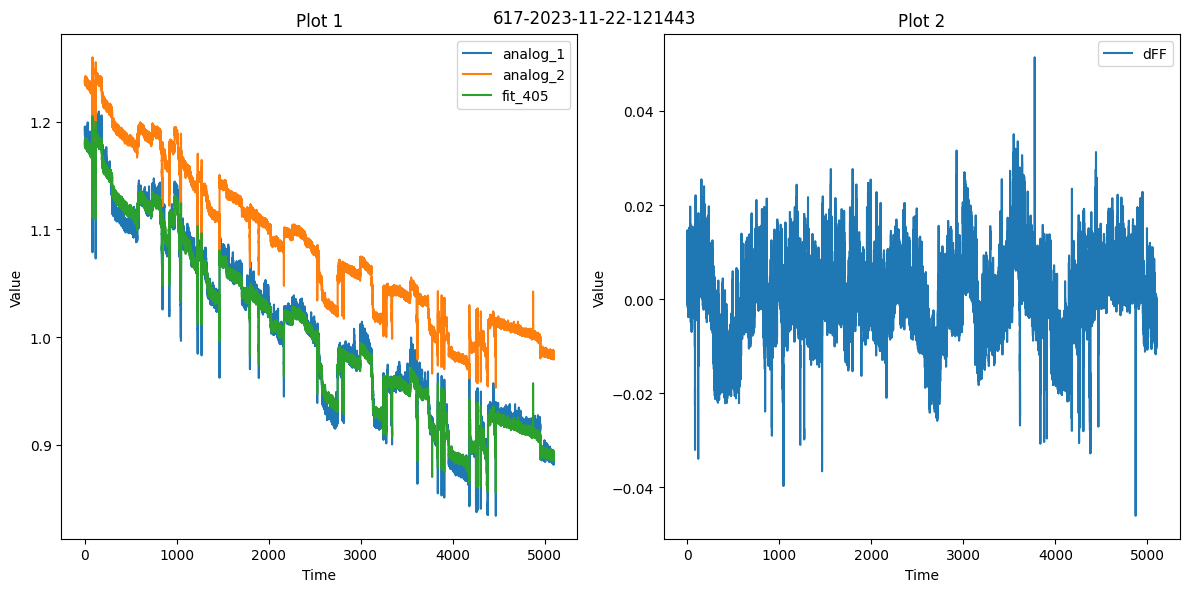

index: (array([1347, 1477, 2777, 2907], dtype=int64),)


In [10]:
# Define the PPD file path
ppd_file_path = r'E:\sensory_stim\fp\617-2023-11-22-121443.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


# Index of np.diff(data['digital_1']) bigger than 0.5 or smaller than -0.5
index = np.where((np.diff(data['digital_1']) > 0.5) | (np.diff(data['digital_1']) < -0.5))

# Print the onsets and offsets
print("index:", index)

dFF = dFF[index[0][0]:]


In [160]:
# Load the Excel file
file_path = 'E:/sensory_stim/JH617_log.xlsx'
excel_data = pd.read_excel(file_path)

# Extract the stimulus (Stim) value from the 'Event' column
excel_data['Stim'] = excel_data['Event'].apply(lambda x: int(x.split(':')[0]))

# Subtract 'ledonset' from the 'Frame' column and convert to string
ledonset = 502
fps = 30
excel_data['Time'] = ((excel_data['Frame'] - ledonset) / fps).astype(str)

# Organize data into a dictionary
data = {
    'Mouse617': {
        'Stim': excel_data['Stim'].tolist(),
        'Time': excel_data['Time'].tolist()
    }
}

# Use `data` as needed in your analysis

stim_data = data['Mouse617']['Stim']
time_stamps = data['Mouse617']['Time']
sampling_rate = 130
fps = 30

pinp_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
weak_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]
mild_indexes = [i for i, stim in enumerate(stim_data) if stim == 2]
hard_indexes = [i for i, stim in enumerate(stim_data) if stim == 3]
cold_indexes = [i for i, stim in enumerate(stim_data) if stim == 4]
room_indexes = [i for i, stim in enumerate(stim_data) if stim == 5]
warm_indexes = [i for i, stim in enumerate(stim_data) if stim == 6]

pinp_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in pinp_indexes]
weak_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in weak_indexes]
mild_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in mild_indexes]
hard_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in hard_indexes]
cold_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in cold_indexes]
room_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in room_indexes]
warm_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in warm_indexes]


trace_duration = 5  # 5 seconds before and 30 seconds after each data index

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Function to analyze and plot data for different index sets
def analyze_and_plot(indexes, dFF, sampling_rate, pre_start=5, post_start=10):
    trace_data_matrix = []

    for index in indexes:
        start = int(index - pre_start * sampling_rate)
        end = int(index + post_start * sampling_rate)
        trace_data = dFF[start:end]
        time = np.arange(start, end) / sampling_rate

        # Calculate the baseline value
        baseline_start = int(index - 5 * sampling_rate)
        baseline_end = int(index - 3 * sampling_rate)
        baseline = np.mean(dFF[baseline_start:baseline_end])

        # Compute the relative trace data
        relative_trace_data = trace_data - baseline

        # Append relative_trace_data to the matrix
        trace_data_matrix.append(relative_trace_data)


    return np.array(trace_data_matrix)

# Example usage for each data index set
trace_data_matrix_pinp = analyze_and_plot(pinp_data_indexes, dFF, sampling_rate)
trace_data_matrix_weak = analyze_and_plot(weak_data_indexes, dFF, sampling_rate)
trace_data_matrix_mild = analyze_and_plot(mild_data_indexes, dFF, sampling_rate)
trace_data_matrix_hard = analyze_and_plot(hard_data_indexes, dFF, sampling_rate)
trace_data_matrix_cold = analyze_and_plot(cold_data_indexes, dFF, sampling_rate)
trace_data_matrix_room = analyze_and_plot(room_data_indexes, dFF, sampling_rate)
trace_data_matrix_warm = analyze_and_plot(warm_data_indexes, dFF, sampling_rate)



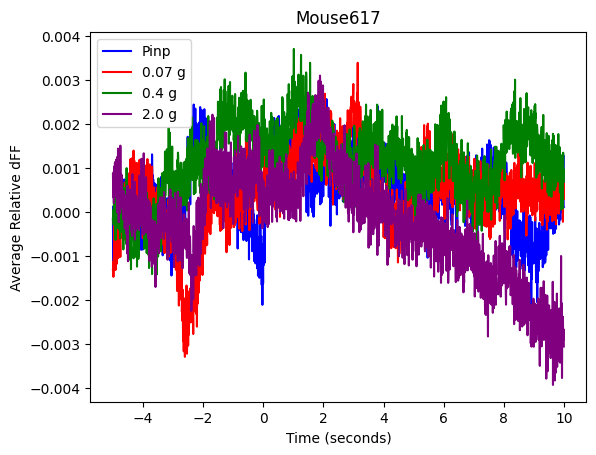

In [161]:
pre_start=5
post_start=10
# Calculate the average trace for water and TMT
average_trace_pinp = np.mean(trace_data_matrix_pinp, axis=0)
average_trace_weak = np.mean(trace_data_matrix_weak, axis=0)
average_trace_mild = np.mean(trace_data_matrix_mild, axis=0)
average_trace_hard = np.mean(trace_data_matrix_hard, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_pinp, label='Pinp', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_weak, label='0.07 g', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_mild, label='0.4 g', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_hard, label='2.0 g', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse617')
plt.legend()
plt.show()

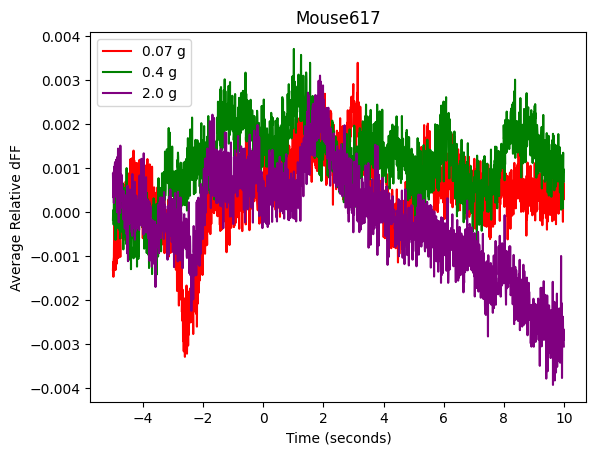

In [163]:
# Calculate the average trace for water and TMT
average_trace_pinp = np.mean(trace_data_matrix_pinp, axis=0)
average_trace_weak = np.mean(trace_data_matrix_weak, axis=0)
average_trace_mild = np.mean(trace_data_matrix_mild, axis=0)
average_trace_hard = np.mean(trace_data_matrix_hard, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_weak, label='0.07 g', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_mild, label='0.4 g', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_hard, label='2.0 g', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse617')
plt.legend()
plt.show()

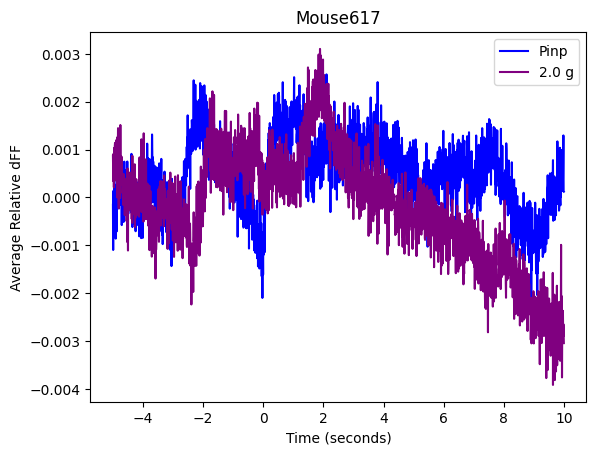

In [165]:
pre_start=5
post_start=10
# Calculate the average trace for water and TMT
average_trace_pinp = np.mean(trace_data_matrix_pinp, axis=0)
average_trace_weak = np.mean(trace_data_matrix_weak, axis=0)
average_trace_mild = np.mean(trace_data_matrix_mild, axis=0)
average_trace_hard = np.mean(trace_data_matrix_hard, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_pinp, label='Pinp', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_hard, label='2.0 g', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse617')
plt.legend()
plt.show()

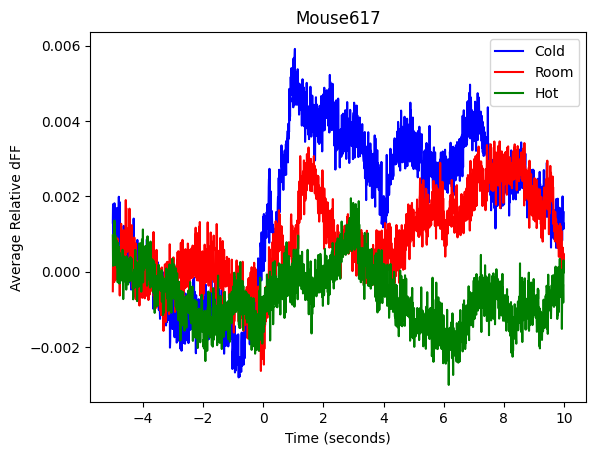

In [166]:
# Calculate the average trace for water and TMT
average_trace_cold = np.mean(trace_data_matrix_cold, axis=0)
average_trace_room = np.mean(trace_data_matrix_room, axis=0)
average_trace_warm = np.mean(trace_data_matrix_warm, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_cold, label='Cold', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_room, label='Room', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_warm, label='Hot', color='green')


plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse617')
plt.legend()
plt.show()

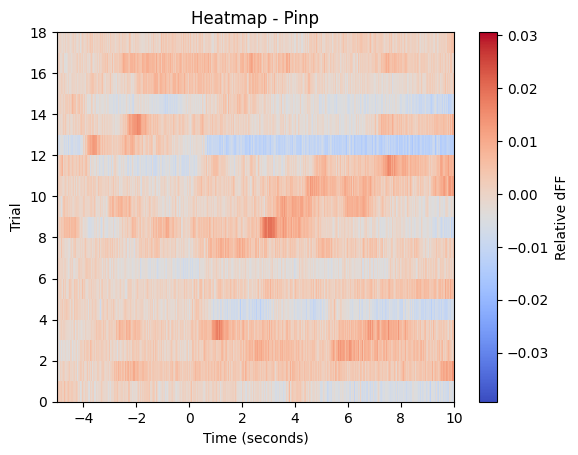

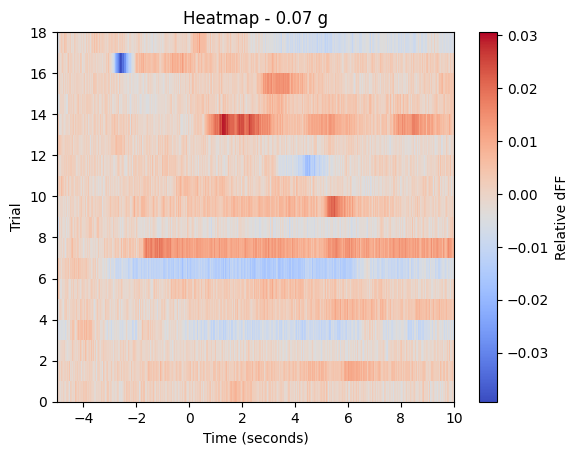

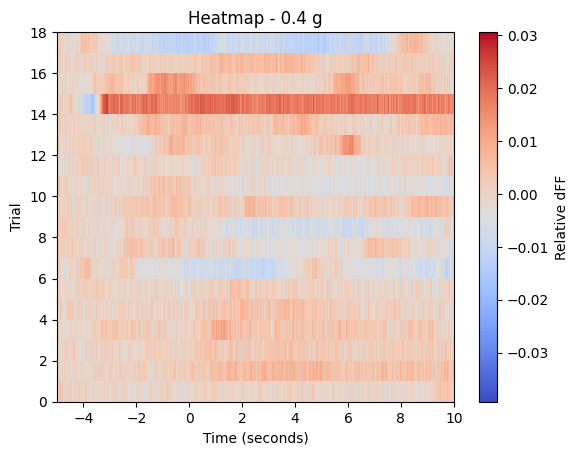

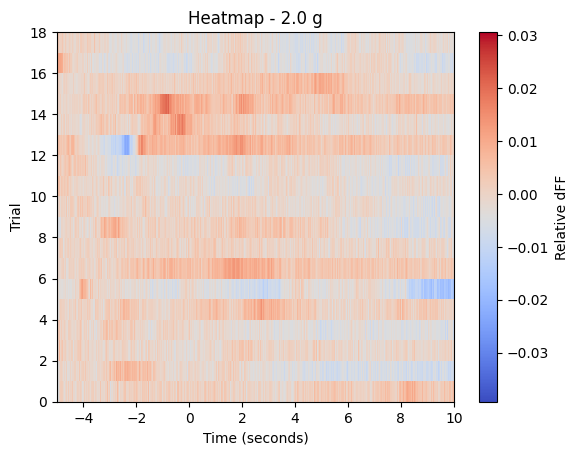

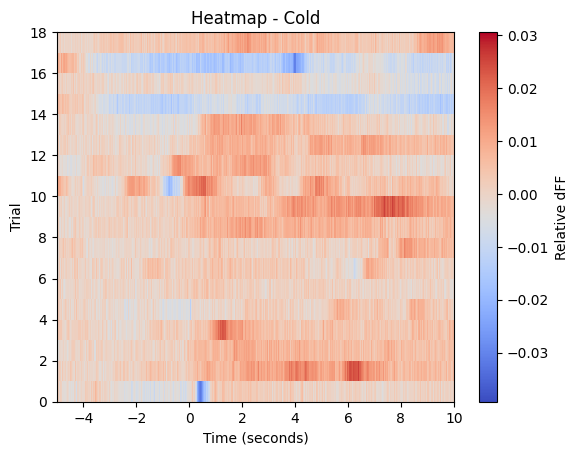

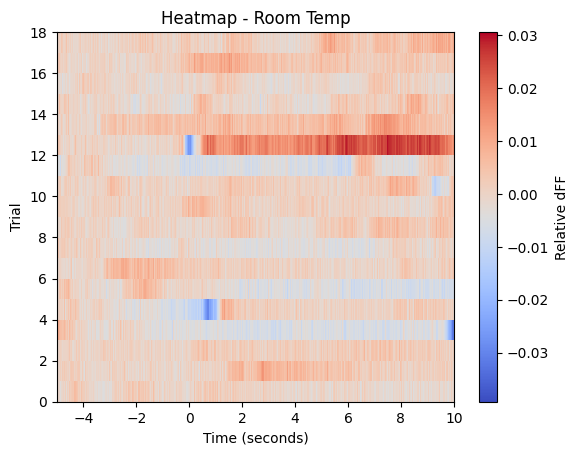

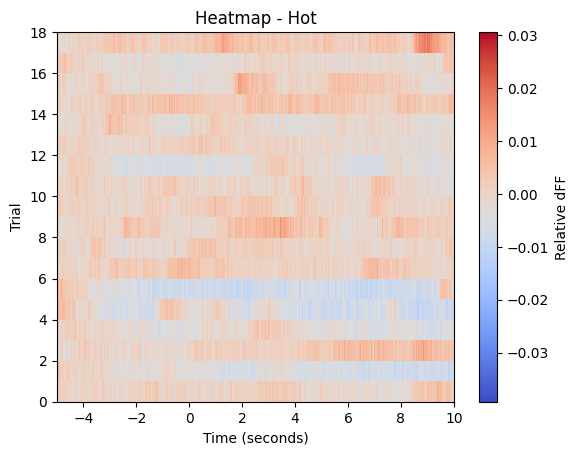

In [167]:
# Find global minimum and maximum values across all datasets for consistent color scaling
min_val = min(np.min(trace_data_matrix_pinp), np.min(trace_data_matrix_weak),
              np.min(trace_data_matrix_mild), np.min(trace_data_matrix_hard),
              np.min(trace_data_matrix_cold), np.min(trace_data_matrix_room),
              np.min(trace_data_matrix_warm))

max_val = max(np.max(trace_data_matrix_pinp), np.max(trace_data_matrix_weak),
              np.max(trace_data_matrix_mild), np.max(trace_data_matrix_hard),
              np.max(trace_data_matrix_cold), np.max(trace_data_matrix_room),
              np.max(trace_data_matrix_warm))

# Function to plot heatmap
def plot_heatmap(data_matrix, title, pre_start, post_start, sampling_rate, vmin, vmax):
    extent = [-pre_start, post_start, 0, data_matrix.shape[0]]
    plt.imshow(data_matrix, aspect='auto', extent=extent, cmap='coolwarm',
               interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Relative dFF')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Trial')
    plt.title(title)
    plt.show()

# Plotting heatmaps with consistent color scaling
plot_heatmap(trace_data_matrix_pinp, 'Heatmap - Pinp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_weak, 'Heatmap - 0.07 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_mild, 'Heatmap - 0.4 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_hard, 'Heatmap - 2.0 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_cold, 'Heatmap - Cold', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_room, 'Heatmap - Room Temp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_warm, 'Heatmap - Hot', pre_start, post_start, sampling_rate, min_val, max_val)


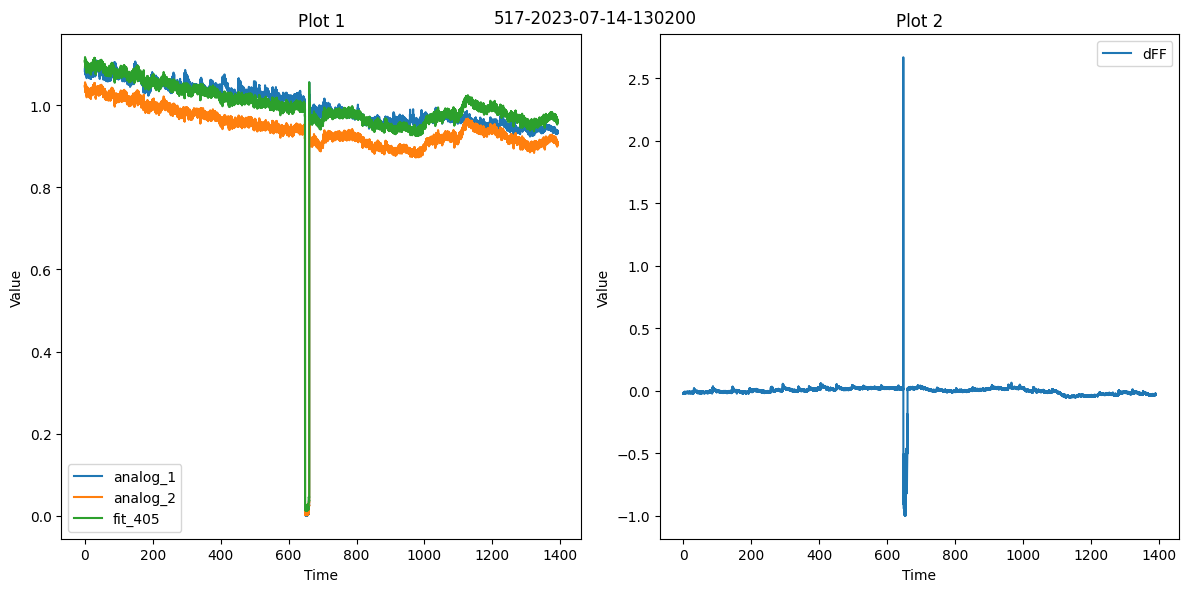

In [26]:
# Define the PPD file path
ppd_file_path = r'H:\fp_test\innate_fear\517-2023-07-14-130200.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


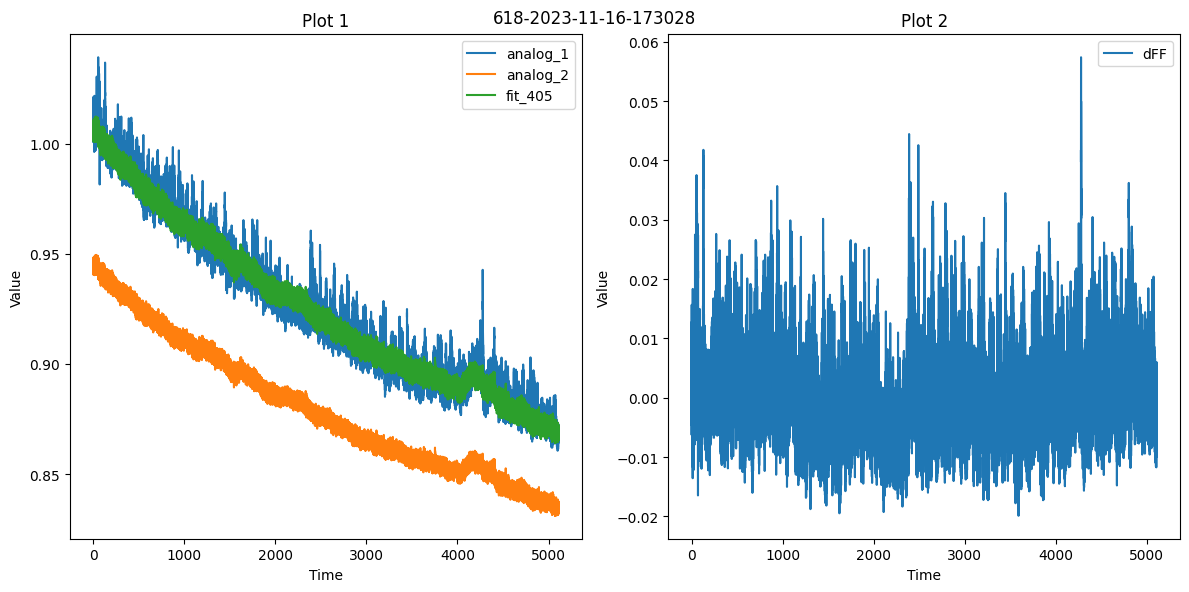

index: (array([1657, 1787, 3087, 3217], dtype=int64),)


In [173]:
# Define the PPD file path
ppd_file_path = r'E:\sensory_stim\fp\618-2023-11-16-173028.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


# Index of np.diff(data['digital_1']) bigger than 0.5 or smaller than -0.5
index = np.where((np.diff(data['digital_1']) > 0.5) | (np.diff(data['digital_1']) < -0.5))

# Print the onsets and offsets
print("index:", index)

dFF = dFF[index[0][0]:]


In [174]:
# Load the Excel file
file_path = 'E:/sensory_stim/JH618_log.xlsx'
excel_data = pd.read_excel(file_path)

# Extract the stimulus (Stim) value from the 'Event' column
excel_data['Stim'] = excel_data['Event'].apply(lambda x: int(x.split(':')[0]))

# Subtract 'ledonset' from the 'Frame' column and convert to string
ledonset = 2470
fps = 30
excel_data['Time'] = ((excel_data['Frame'] - ledonset) / fps).astype(str)

# Organize data into a dictionary
data = {
    'Mouse618': {
        'Stim': excel_data['Stim'].tolist(),
        'Time': excel_data['Time'].tolist()
    }
}

# Use `data` as needed in your analysis

stim_data = data['Mouse618']['Stim']
time_stamps = data['Mouse618']['Time']
sampling_rate = 130
fps = 30

pinp_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
weak_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]
mild_indexes = [i for i, stim in enumerate(stim_data) if stim == 2]
hard_indexes = [i for i, stim in enumerate(stim_data) if stim == 3]
cold_indexes = [i for i, stim in enumerate(stim_data) if stim == 4]
room_indexes = [i for i, stim in enumerate(stim_data) if stim == 5]
warm_indexes = [i for i, stim in enumerate(stim_data) if stim == 6]

pinp_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in pinp_indexes]
weak_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in weak_indexes]
mild_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in mild_indexes]
hard_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in hard_indexes]
cold_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in cold_indexes]
room_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in room_indexes]
warm_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in warm_indexes]


trace_duration = 5  # 5 seconds before and 30 seconds after each data index

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Function to analyze and plot data for different index sets
def analyze_and_plot(indexes, dFF, sampling_rate, pre_start=5, post_start=10):
    trace_data_matrix = []

    for index in indexes:
        start = int(index - pre_start * sampling_rate)
        end = int(index + post_start * sampling_rate)
        trace_data = dFF[start:end]
        time = np.arange(start, end) / sampling_rate

        # Calculate the baseline value
        baseline_start = int(index - 5 * sampling_rate)
        baseline_end = int(index - 3 * sampling_rate)
        baseline = np.mean(dFF[baseline_start:baseline_end])

        # Compute the relative trace data
        relative_trace_data = trace_data - baseline

        # Append relative_trace_data to the matrix
        trace_data_matrix.append(relative_trace_data)


    return np.array(trace_data_matrix)

# Example usage for each data index set
trace_data_matrix_pinp = analyze_and_plot(pinp_data_indexes, dFF, sampling_rate)
trace_data_matrix_weak = analyze_and_plot(weak_data_indexes, dFF, sampling_rate)
trace_data_matrix_mild = analyze_and_plot(mild_data_indexes, dFF, sampling_rate)
trace_data_matrix_hard = analyze_and_plot(hard_data_indexes, dFF, sampling_rate)
trace_data_matrix_cold = analyze_and_plot(cold_data_indexes, dFF, sampling_rate)
trace_data_matrix_room = analyze_and_plot(room_data_indexes, dFF, sampling_rate)
trace_data_matrix_warm = analyze_and_plot(warm_data_indexes, dFF, sampling_rate)



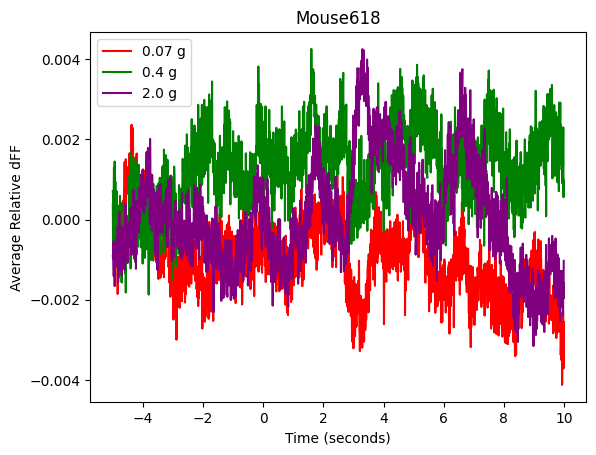

In [179]:
# Calculate the average trace for water and TMT
average_trace_pinp = np.mean(trace_data_matrix_pinp, axis=0)
average_trace_weak = np.mean(trace_data_matrix_weak, axis=0)
average_trace_mild = np.mean(trace_data_matrix_mild, axis=0)
average_trace_hard = np.mean(trace_data_matrix_hard, axis=0)

#plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_pinp, label='Pinp', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_weak, label='0.07 g', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_mild, label='0.4 g', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_hard, label='2.0 g', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse618')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (650,) and (0,)

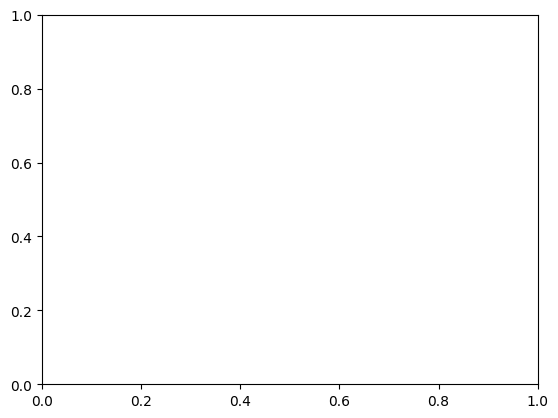

In [182]:
pre_start= 5
post_start = 10
# Calculate the average trace for water and TMT
average_trace_cold = np.mean(trace_data_matrix_cold, axis=0)
average_trace_room = np.mean(trace_data_matrix_room, axis=0)
average_trace_warm = np.mean(trace_data_matrix_warm, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_cold[-pre_start*sampling_rate:post_start*sampling_rate], label='Cold', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_room, label='Room', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_warm, label='Hot', color='green')


plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse618')
plt.legend()
plt.show()

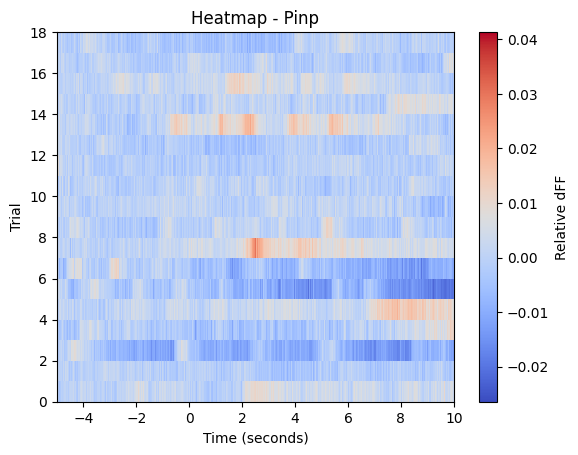

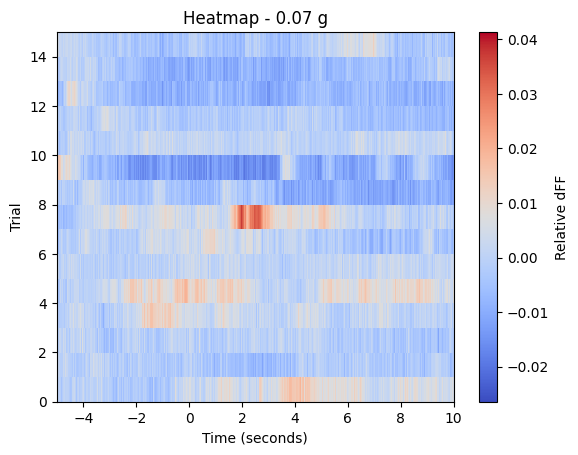

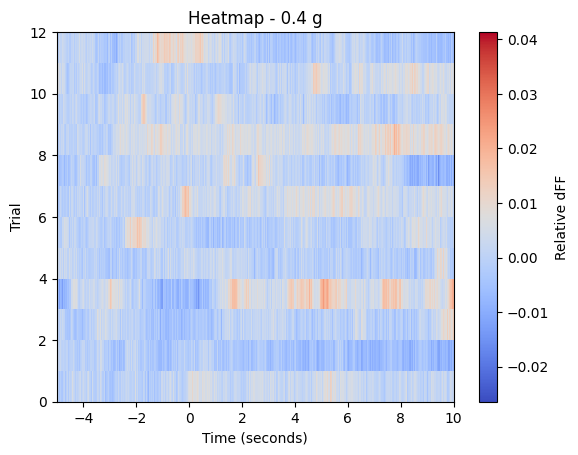

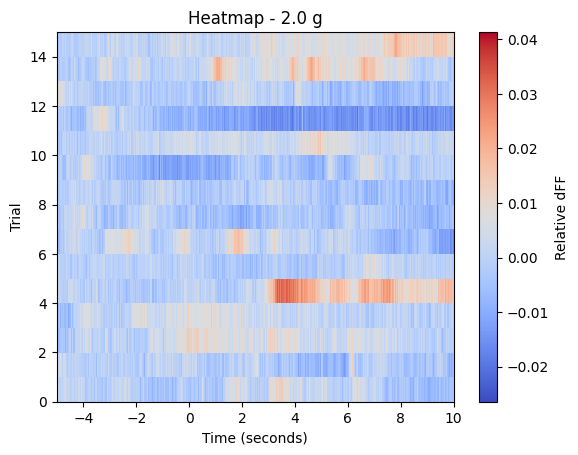

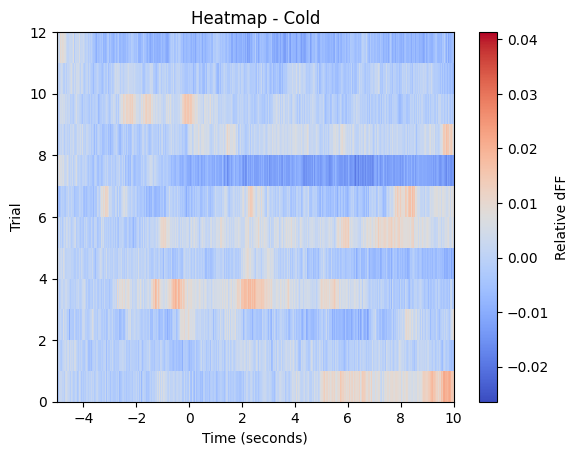

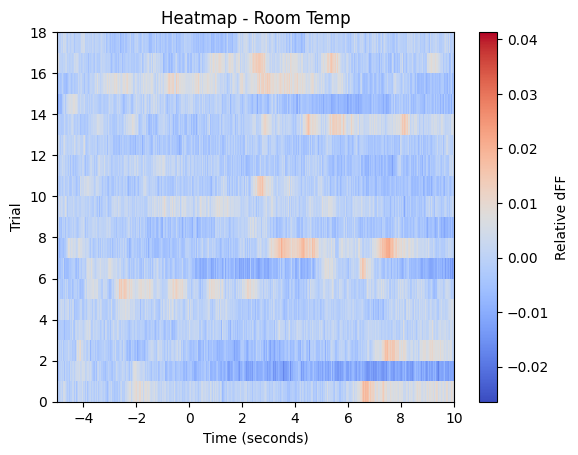

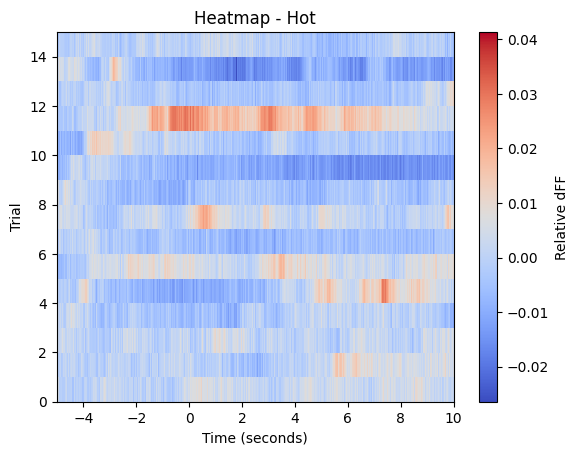

In [177]:
# Find global minimum and maximum values across all datasets for consistent color scaling
min_val = min(np.min(trace_data_matrix_pinp), np.min(trace_data_matrix_weak),
              np.min(trace_data_matrix_mild), np.min(trace_data_matrix_hard),
              np.min(trace_data_matrix_cold), np.min(trace_data_matrix_room),
              np.min(trace_data_matrix_warm))

max_val = max(np.max(trace_data_matrix_pinp), np.max(trace_data_matrix_weak),
              np.max(trace_data_matrix_mild), np.max(trace_data_matrix_hard),
              np.max(trace_data_matrix_cold), np.max(trace_data_matrix_room),
              np.max(trace_data_matrix_warm))

# Function to plot heatmap
def plot_heatmap(data_matrix, title, pre_start, post_start, sampling_rate, vmin, vmax):
    extent = [-pre_start, post_start, 0, data_matrix.shape[0]]
    plt.imshow(data_matrix, aspect='auto', extent=extent, cmap='coolwarm',
               interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Relative dFF')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Trial')
    plt.title(title)
    plt.show()

# Plotting heatmaps with consistent color scaling
plot_heatmap(trace_data_matrix_pinp, 'Heatmap - Pinp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_weak, 'Heatmap - 0.07 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_mild, 'Heatmap - 0.4 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_hard, 'Heatmap - 2.0 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_cold, 'Heatmap - Cold', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_room, 'Heatmap - Room Temp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_warm, 'Heatmap - Hot', pre_start, post_start, sampling_rate, min_val, max_val)


### Process single PPD file

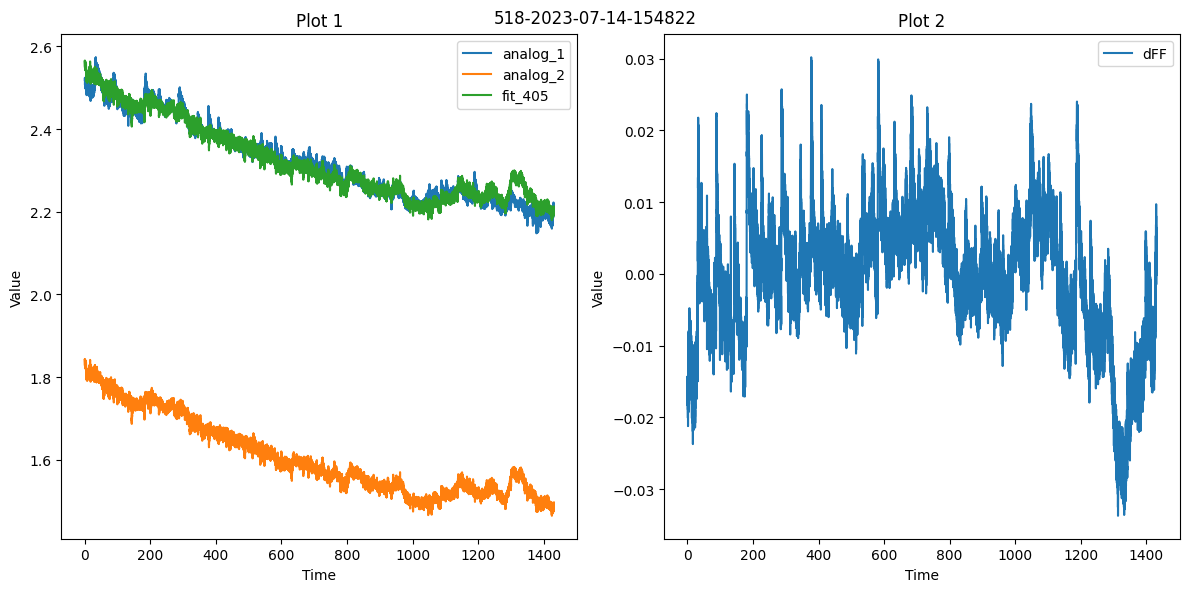

In [32]:
# Define the PPD file path
ppd_file_path = r'H:\fp_test\innate_fear\518-2023-07-14-154822.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


In [33]:
data = {
    'UniBe006': 
            {'Stim': [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1], 
             'Time': ['00:30', '01:25', '02:22', '03:00', '03:46', '04:45', '05:44', '06:16', '06:47', '07:19', 
                    '08:07', '08:53', '09:39', '10:30', '11:21', '12:06', '12:38', '13:16', '14:08', '14:57', 
                    '15:48', '16:40', '17:26', '18:04', '18:56', '19:49', '20:29', '21:22', '22:22', '23:17']}
}

stim_data = data['UniBe006']['Stim']
time_stamps = data['UniBe006']['Time']
sampling_rate = 130

def time_stamp_to_seconds(time_stamp):
    minutes, seconds = time_stamp.split(':')
    return int(minutes) * 60 + int(seconds)

water_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
tmt_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]

water_time_stamps = [time_stamps[i] for i in water_indexes]
tmt_time_stamps = [time_stamps[i] for i in tmt_indexes]

water_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in water_time_stamps]
tmt_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in tmt_time_stamps]

print("Water Indexes:", water_indexes)
print("Water Time Stamps:", water_time_stamps)
print("Water Data Indexes:", water_data_indexes)

print("TMT Indexes:", tmt_indexes)
print("TMT Time Stamps:", tmt_time_stamps)
print("TMT Data Indexes:", tmt_data_indexes)


Water Indexes: [0, 2, 4, 6, 7, 11, 12, 14, 16, 18, 22, 23, 24, 26, 28]
Water Time Stamps: ['00:30', '02:22', '03:46', '05:44', '06:16', '08:53', '09:39', '11:21', '12:38', '14:08', '17:26', '18:04', '18:56', '20:29', '22:22']
Water Data Indexes: [3900, 18460, 29380, 44720, 48880, 69290, 75270, 88530, 98540, 110240, 135980, 140920, 147680, 159770, 174460]
TMT Indexes: [1, 3, 5, 8, 9, 10, 13, 15, 17, 19, 20, 21, 25, 27, 29]
TMT Time Stamps: ['01:25', '03:00', '04:45', '06:47', '07:19', '08:07', '10:30', '12:06', '13:16', '14:57', '15:48', '16:40', '19:49', '21:22', '23:17']
TMT Data Indexes: [11050, 23400, 37050, 52910, 57070, 63310, 81900, 94380, 103480, 116610, 123240, 130000, 154570, 166660, 181610]


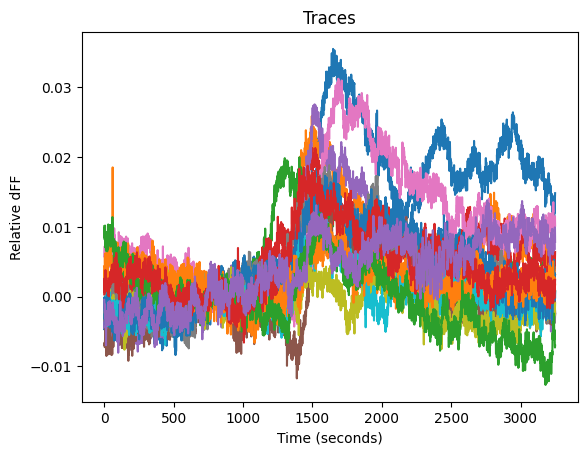

In [34]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in water_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_water = np.array(trace_data_matrix)


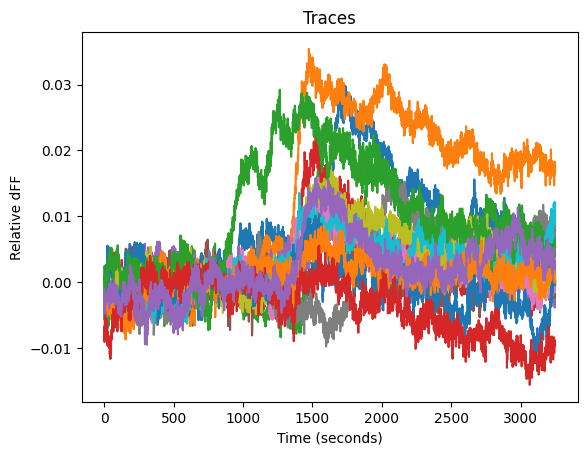

In [35]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in tmt_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_tmt = np.array(trace_data_matrix)


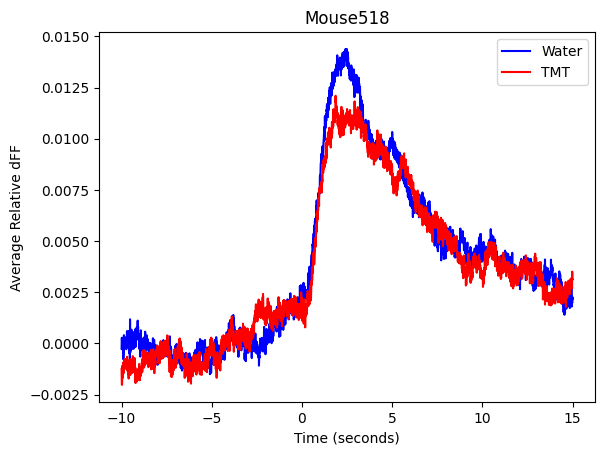

In [36]:
# Calculate the average trace for water and TMT
average_trace_water = np.mean(trace_data_matrix_water, axis=0)
average_trace_tmt = np.mean(trace_data_matrix_tmt, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water, label='Water', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt, label='TMT', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse518')
plt.legend()
plt.show()

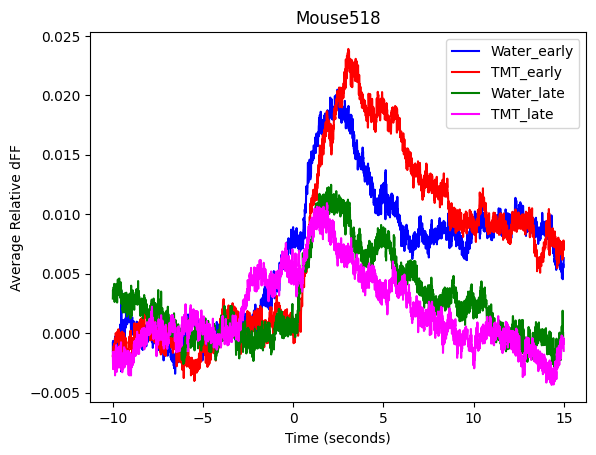

In [37]:
# Calculate the average trace for water and TMT
average_trace_water_early = np.mean(trace_data_matrix_water[0:4,:], axis=0)
average_trace_tmt_early = np.mean(trace_data_matrix_tmt[0:4,:], axis=0)
average_trace_water_late = np.mean(trace_data_matrix_water[10:14,:], axis=0)
average_trace_tmt_late = np.mean(trace_data_matrix_tmt[10:14,:], axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_early, label='Water_early', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_early, label='TMT_early', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_late, label='Water_late', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_late, label='TMT_late', color='magenta')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse518')
plt.legend()
plt.show()

In [4]:
# Define the PPD file path
ppd_file_path = r'E:\sensory_stim\fp\519-2023-11-24-174207.ppd'

# Load the Excel file
file_path = 'E:/sensory_stim/JH519_log.xlsx'
excel_data = pd.read_excel(file_path)

# Extract the stimulus (Stim) value from the 'Event' column
excel_data['Stim'] = excel_data['Event'].apply(lambda x: int(x.split(':')[0]))

# Subtract 'ledonset' from the 'Frame' column and convert to string
ledonset = 533
pre_start = 10
post_start = 20

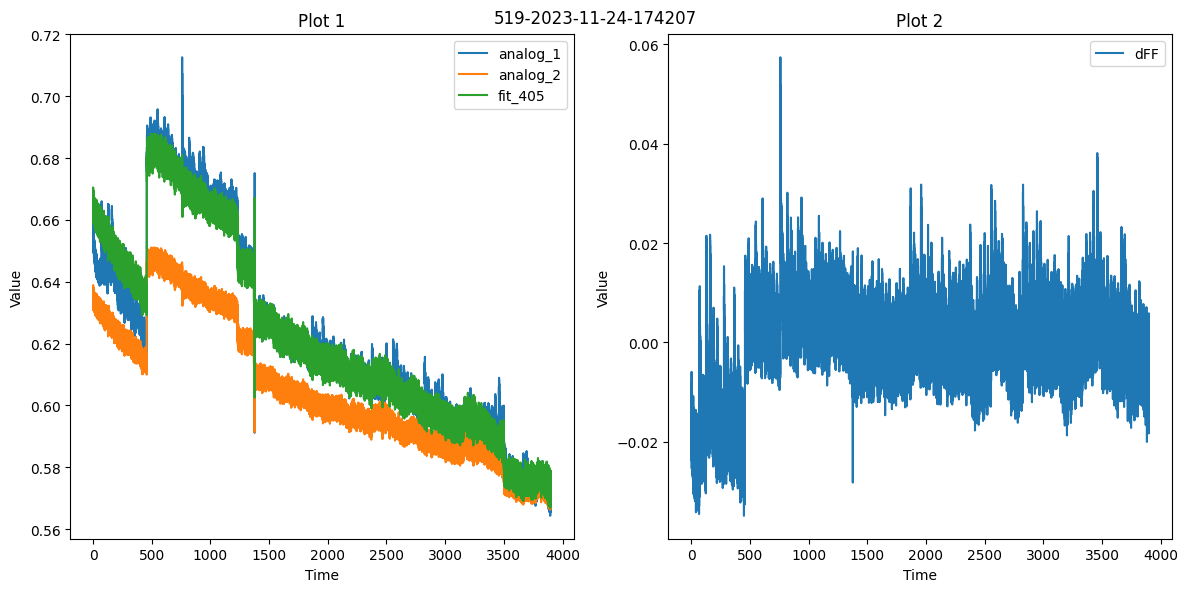

index: (array([1555, 1685, 2985, 3115], dtype=int64),)


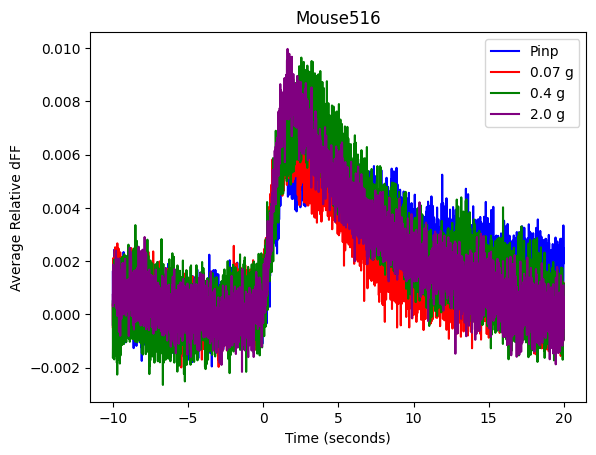

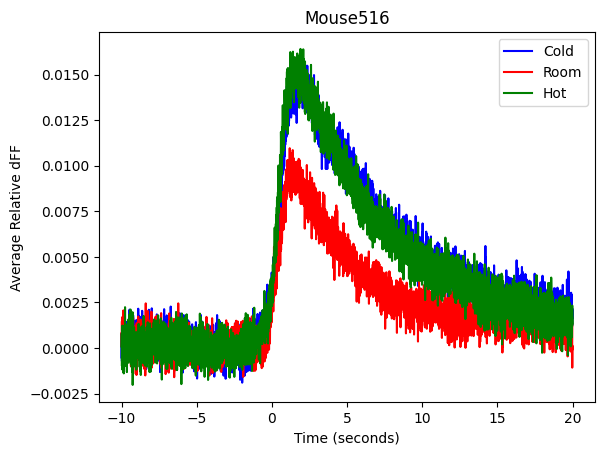

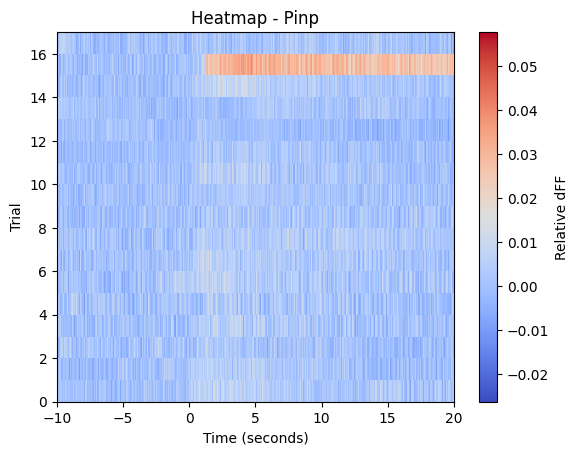

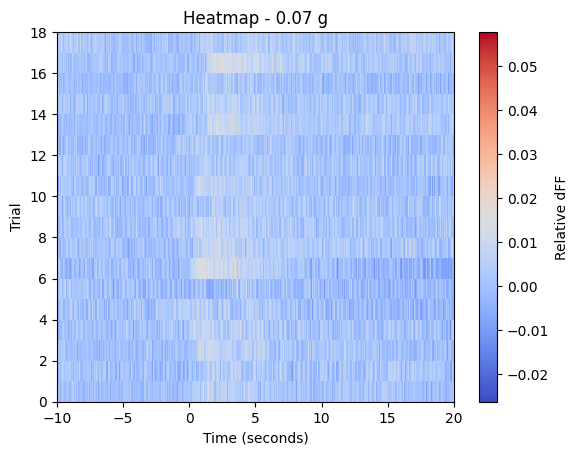

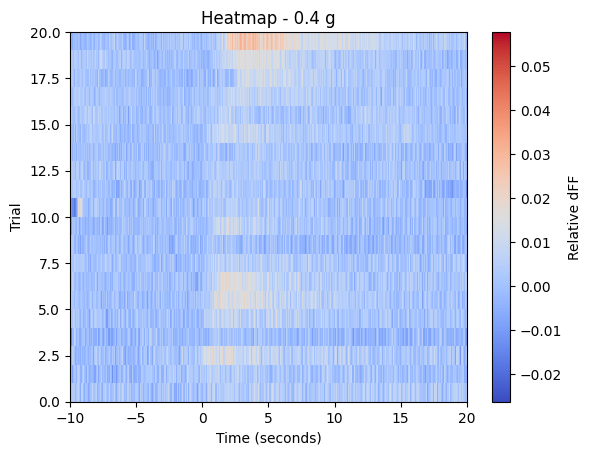

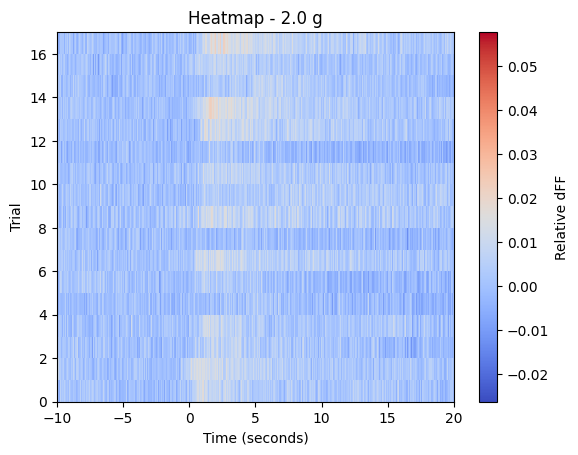

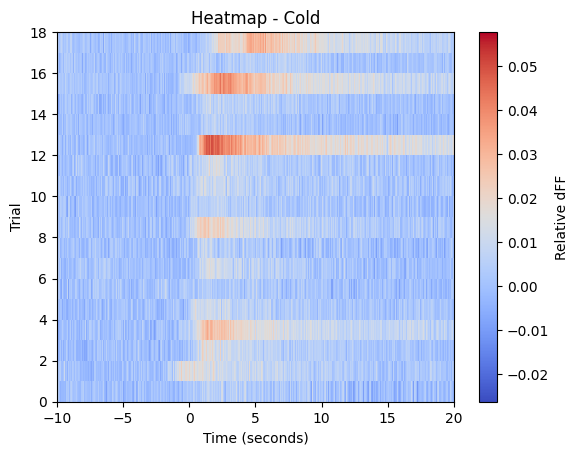

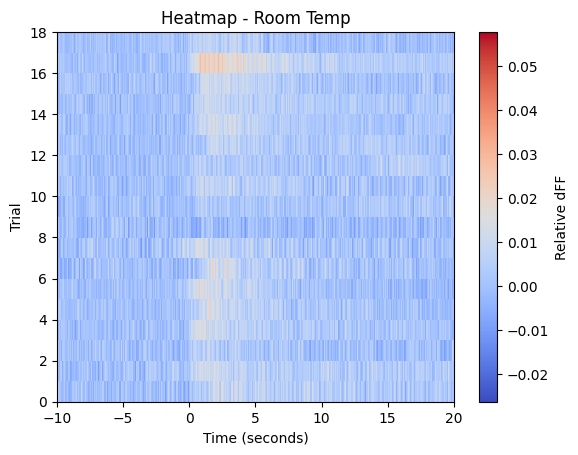

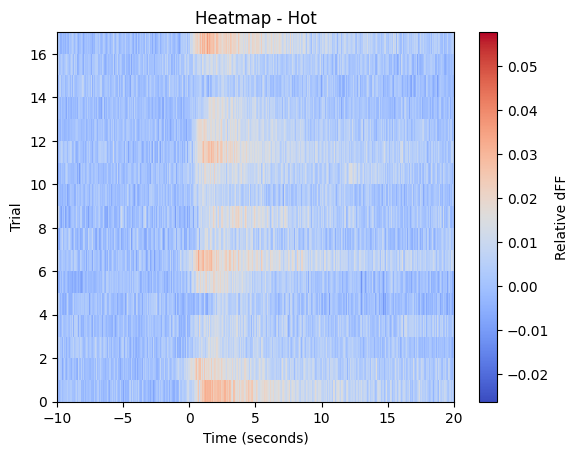

In [5]:

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


# Index of np.diff(data['digital_1']) bigger than 0.5 or smaller than -0.5
index = np.where((np.diff(data['digital_1']) > 0.5) | (np.diff(data['digital_1']) < -0.5))

# Print the onsets and offsets
print("index:", index)

dFF = dFF[index[0][0]:]

## 
fps = 30
excel_data['Time'] = ((excel_data['Frame'] - ledonset) / fps).astype(str)

# Organize data into a dictionary
data = {
    'Mouse618': {
        'Stim': excel_data['Stim'].tolist(),
        'Time': excel_data['Time'].tolist()
    }
}

# Use `data` as needed in your analysis

stim_data = data['Mouse618']['Stim']
time_stamps = data['Mouse618']['Time']
sampling_rate = 130
fps = 30

pinp_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
weak_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]
mild_indexes = [i for i, stim in enumerate(stim_data) if stim == 2]
hard_indexes = [i for i, stim in enumerate(stim_data) if stim == 3]
cold_indexes = [i for i, stim in enumerate(stim_data) if stim == 4]
room_indexes = [i for i, stim in enumerate(stim_data) if stim == 5]
warm_indexes = [i for i, stim in enumerate(stim_data) if stim == 6]

pinp_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in pinp_indexes]
weak_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in weak_indexes]
mild_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in mild_indexes]
hard_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in hard_indexes]
cold_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in cold_indexes]
room_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in room_indexes]
warm_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in warm_indexes]


trace_duration = 5  # 5 seconds before and 30 seconds after each data index

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Function to analyze and plot data for different index sets
def analyze_and_plot(indexes, dFF, sampling_rate, pre_start=10, post_start=20):
    trace_data_matrix = []

    for index in indexes:
        start = int(index - pre_start * sampling_rate)
        end = int(index + post_start * sampling_rate)
        trace_data = dFF[start:end]
        time = np.arange(start, end) / sampling_rate

        # Calculate the baseline value
        baseline_start = int(index - 5 * sampling_rate)
        baseline_end = int(index - 3 * sampling_rate)
        baseline = np.mean(dFF[baseline_start:baseline_end])

        # Compute the relative trace data
        relative_trace_data = trace_data - baseline

        # Append relative_trace_data to the matrix
        trace_data_matrix.append(relative_trace_data)


    return np.array(trace_data_matrix)

# Example usage for each data index set
trace_data_matrix_pinp = analyze_and_plot(pinp_data_indexes, dFF, sampling_rate)
trace_data_matrix_weak = analyze_and_plot(weak_data_indexes, dFF, sampling_rate)
trace_data_matrix_mild = analyze_and_plot(mild_data_indexes, dFF, sampling_rate)
trace_data_matrix_hard = analyze_and_plot(hard_data_indexes, dFF, sampling_rate)
trace_data_matrix_cold = analyze_and_plot(cold_data_indexes, dFF, sampling_rate)
trace_data_matrix_room = analyze_and_plot(room_data_indexes, dFF, sampling_rate)
trace_data_matrix_warm = analyze_and_plot(warm_data_indexes, dFF, sampling_rate)

# Calculate the average trace for water and TMT
average_trace_pinp = np.mean(trace_data_matrix_pinp, axis=0)
average_trace_weak = np.mean(trace_data_matrix_weak, axis=0)
average_trace_mild = np.mean(trace_data_matrix_mild, axis=0)
average_trace_hard = np.mean(trace_data_matrix_hard, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_pinp, label='Pinp', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_weak, label='0.07 g', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_mild, label='0.4 g', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_hard, label='2.0 g', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse516')
plt.legend()
plt.show()


# Calculate the average trace for water and TMT
average_trace_cold = np.mean(trace_data_matrix_cold, axis=0)
average_trace_room = np.mean(trace_data_matrix_room, axis=0)
average_trace_warm = np.mean(trace_data_matrix_warm, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_cold, label='Cold', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_room, label='Room', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_warm, label='Hot', color='green')


plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse516')
plt.legend()
plt.show()

# Find global minimum and maximum values across all datasets for consistent color scaling
min_val = min(np.min(trace_data_matrix_pinp), np.min(trace_data_matrix_weak),
              np.min(trace_data_matrix_mild), np.min(trace_data_matrix_hard),
              np.min(trace_data_matrix_cold), np.min(trace_data_matrix_room),
              np.min(trace_data_matrix_warm))

max_val = max(np.max(trace_data_matrix_pinp), np.max(trace_data_matrix_weak),
              np.max(trace_data_matrix_mild), np.max(trace_data_matrix_hard),
              np.max(trace_data_matrix_cold), np.max(trace_data_matrix_room),
              np.max(trace_data_matrix_warm))

# Function to plot heatmap
def plot_heatmap(data_matrix, title, pre_start, post_start, sampling_rate, vmin, vmax):
    extent = [-pre_start, post_start, 0, data_matrix.shape[0]]
    plt.imshow(data_matrix, aspect='auto', extent=extent, cmap='coolwarm',
               interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Relative dFF')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Trial')
    plt.title(title)
    plt.show()

# Plotting heatmaps with consistent color scaling
plot_heatmap(trace_data_matrix_pinp, 'Heatmap - Pinp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_weak, 'Heatmap - 0.07 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_mild, 'Heatmap - 0.4 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_hard, 'Heatmap - 2.0 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_cold, 'Heatmap - Cold', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_room, 'Heatmap - Room Temp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_warm, 'Heatmap - Hot', pre_start, post_start, sampling_rate, min_val, max_val)


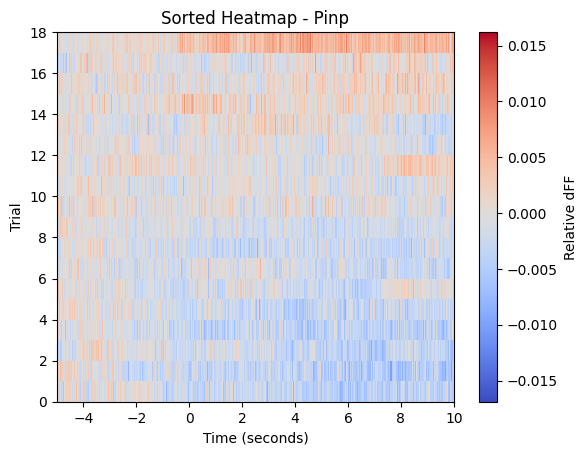

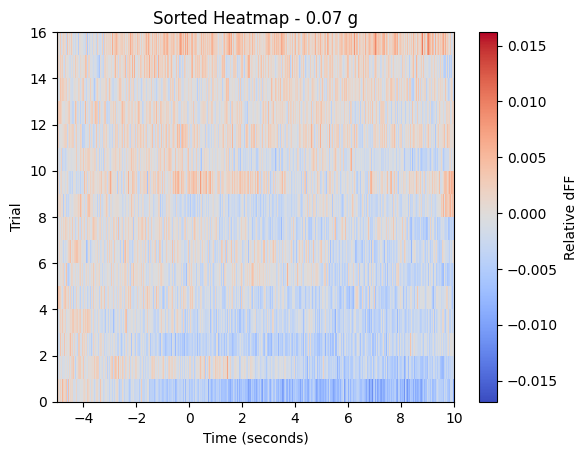

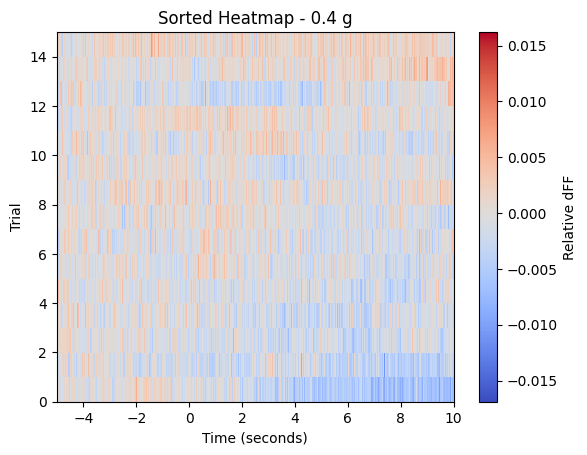

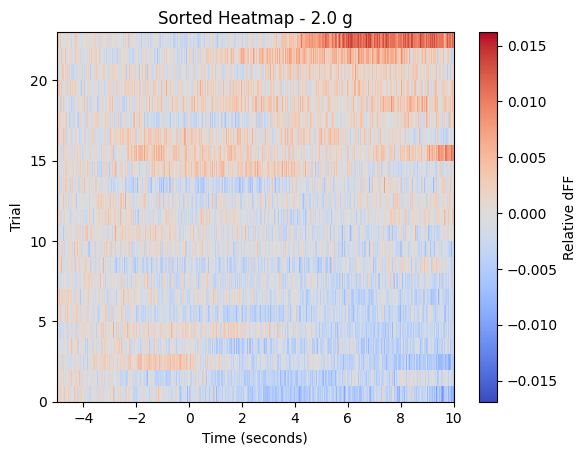

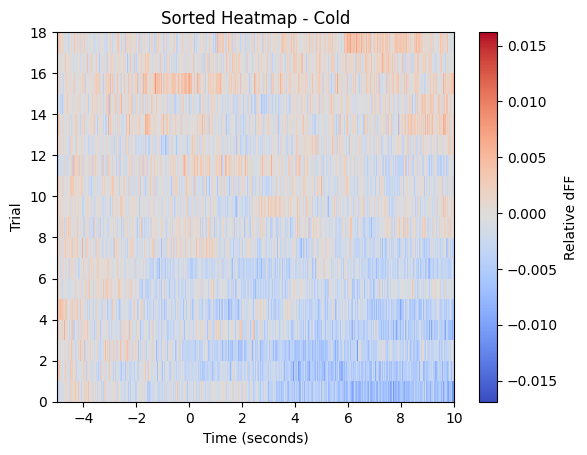

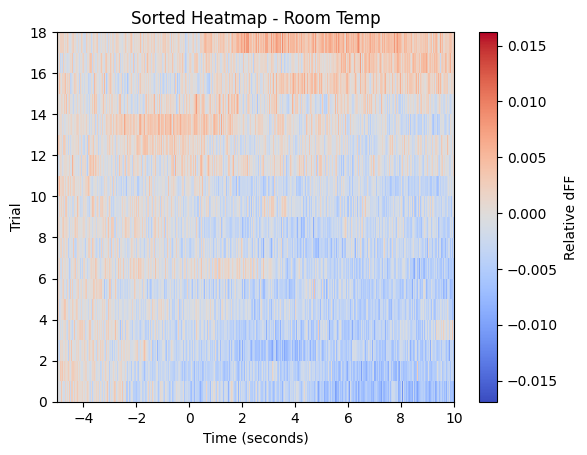

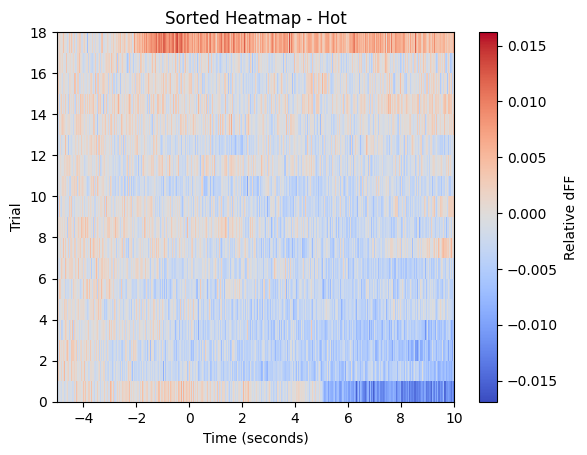

In [21]:
def plot_sorted_heatmap(data_matrix, title, pre_start, post_start, sampling_rate, vmin, vmax):
    # Calculate the average activity in the 0-2 second post-start period
    post_start_index = int(post_start * sampling_rate)
    post_end_index = int((post_start + 2) * sampling_rate)
    avg_activity = np.mean(data_matrix[:, post_start_index:post_end_index], axis=1)

    # Sort the data matrix based on the average activity (high to low)
    sorted_indexes = np.argsort(-avg_activity)
    sorted_data_matrix = data_matrix[sorted_indexes]

    # Plot the heatmap
    extent = [-pre_start, post_start, 0, sorted_data_matrix.shape[0]]
    plt.imshow(sorted_data_matrix, aspect='auto', extent=extent, cmap='coolwarm',
               interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Relative dFF')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Trial')
    plt.title(title)
    plt.show()

# Plotting heatmaps with consistent color scaling and sorted rows
plot_sorted_heatmap(trace_data_matrix_pinp, 'Sorted Heatmap - Pinp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_weak, 'Sorted Heatmap - 0.07 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_mild, 'Sorted Heatmap - 0.4 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_hard, 'Sorted Heatmap - 2.0 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_cold, 'Sorted Heatmap - Cold', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_room, 'Sorted Heatmap - Room Temp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_warm, 'Sorted Heatmap - Hot', pre_start, post_start, sampling_rate, min_val, max_val)
